## Pre-MCMC calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import astropy
import scipy.integrate as integrate
import pandas
from astropy.cosmology import FlatLambdaCDM

In [2]:
# Importing constants 

Planck = astropy.cosmology.realizations.Planck18

T_CMB = Planck.Tcmb0  # Temperature of the CMB
H_0 = Planck.H0  # Current Hubble constant
Omega_m = Planck.Om0  # Matter density parameter
Omega_lambda = Planck.Ode0  # Dark energy density parameter
c = astropy.constants.c.to('km/s')  # Speed of light in km/s
sigma_T = astropy.constants.sigma_T.to('km2')  # Thomson scattering cross-section in km^2


# Setting parameters

z = 8  # Redshift of the quasar bubbles 
f_H = 0.21  # fraction of neutral hydrogen at z = 8

In [3]:
# Input Data

data = pandas.read_csv('Data/u_0.0pc_noise.csv')

Ang_deg = np.array(data['radius_y'])  # In arcmins
amp = np.array(data['amp_y']) * 1e-6  # Amplitude in K

In [4]:
# Importing the Flat Lambda CDM model

cosmo = FlatLambdaCDM(H0=H_0.value, Om0=Omega_m, Tcmb0= T_CMB.value)


# Obtaining the angular diameter distance at z

D_A = cosmo.angular_diameter_distance(z)  # units: Mpc/radian


# Defining a function that converts from our angular distance to proper distance

def AngToDist(Ang_deg= Ang_deg):
    
    Ang_rad = Ang_deg * np.pi / (180 * 60)  # Convert arcmins to radians
    Distance = D_A * Ang_rad  # Convert angular distance to actual distance

    return Distance


In [5]:
# Calculating the actual radii of the bubbles and y

Radius = AngToDist(Ang_deg)  # in Mpc

y = amp / T_CMB.value  

In [6]:
# Calculating n_e and n_H

n_e = y * 3 * np.sqrt(1+z) / (sigma_T * 0.001 * 2 * Radius.to('km'))

n_H = n_e / (1 - f_H)  # Assuming all electrons are from ionized hydrogen
n_H

<Quantity [6.54207985e+11, 6.90633258e+11, 6.41929948e+11, 5.99640868e+11,
           5.97269468e+11, 5.76546427e+11, 4.69119497e+11, 6.02224555e+11] 1 / km3>

In [7]:
# Converting into logarithmic scale

n_H_log = np.log10(n_H.value)  # in log10 units
Radius_log = np.log10(Radius.to('km').value)  # Converting to km then to log10 units

----

## MCMC Sampling

In [8]:
# Defining the model using the Stromgren sphere approximation

def model(theta, n_H_log): 
    N_dot_log, t_Q_log = theta
    return (1/3) * (np.log10(3/(4 * np.pi)) + N_dot_log + t_Q_log - n_H_log) - np.log10(1 + z)
    # return (((3*N_dot*t_Q)/(4*np.pi*n_H))**(1/3)) * (1+z)**(-1)

In [9]:
# Setting up initial, lower and upper bounds for the parameters

N_dot_ini = 58 # in s^-1
N_dot_min = 54   # in s^-1
N_dot_max = 66  # in s^-1

t_Q_ini = 10**7  # in years
t_Q_ini = t_Q_ini * 3.156e7  # in s
t_Q_ini = np.log10(t_Q_ini)  # in log10 units
t_Q_min = 10**5  # in years
t_Q_min = t_Q_min * 3.156e7  # in s
t_Q_min = np.log10(t_Q_min)  # in log10 units
t_Q_max = 10**10  # in years
t_Q_max = t_Q_max * 3.156e7  # in s
t_Q_max = np.log10(t_Q_max)  # in log10 units

In [10]:
# Calculating error in the diameter

Ang_err = np.array([0.1] * len(Ang_deg))  # Error in determining the angular diameter in arcmins
Radius_err = Ang_err * np.pi / (180 * 60) * D_A  # Convert angular error to actual diameter error

Radius_err = np.log10(Radius_err.value)  # Convert to log10 units

In [11]:
# Defining the log-likelihood function

def lnlike(theta, x, y, y_err):
    return -0.5 * np.sum(((y - model(theta, x)) / y_err) ** 2)

# Defining the log-prior function

def lnprior(theta):
    N_dot, t_Q = theta
    if N_dot < N_dot_min or t_Q < t_Q_min or N_dot > N_dot_max  or t_Q > t_Q_max:
        return -np.inf
    return 0.0

# Defining the log-posterior function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


In [12]:
# Setting initial values for the parameters
initial = [N_dot_ini, t_Q_ini]  

# Setting up the MCMC sampler
ndim = len(initial)
nwalkers = 5 * ndim    # Preferentially 3-5 times the number of dimensions (minimum 2 times the number of dimensions)
n_burn = 2000
n_steps = 100000

# Initializing the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n_H_log, Radius_log, Radius_err))

# Adding little variation to the initial positions
p0 = []
for i in range(nwalkers):
    pos = [N_dot_ini, t_Q_ini]  # Start with the initial values
    pos[0] = pos[0] + 1e-4 * pos[0] * np.random.random(1)[0]  # Adding a small random variation to N_dot
    pos[1] = pos[1] + 1e-4 * pos[1] * np.random.random(1)[0]  # Adding a small random variation to t_Q
    p0.append(pos)   


In [13]:
# Running the MCMC sampler

# Burn-in phase
print("Running burn-in phase...")
sampler.reset()
state = sampler.run_mcmc(p0, n_burn, progress=True)
sampler.reset()

# Main sampling phase
print("Running main sampling phase...")
pos, prob, state = sampler.run_mcmc(state, n_steps, progress=True)

# Extracting the samples
samples = sampler.get_chain(flat=True)      # Flatten the chain to get all samples in a single array


Running burn-in phase...


100%|██████████| 2000/2000 [00:01<00:00, 1874.69it/s]


Running main sampling phase...


100%|██████████| 100000/100000 [00:47<00:00, 2089.41it/s]


In [14]:
theta_max = samples[np.argmax(sampler.flatlnprobability)]
print("N_dot_log:", theta_max[0], "; t_Q_log:", theta_max[1])
print("N_dot:", 10**theta_max[0], "; t_Q (in years):", f"{10**theta_max[1] / 3.156e7:.9e}" )

N_dot_log: 62.56281153138948 ; t_Q_log: 14.388434804523396
N_dot: 3.654361706850547e+62 ; t_Q (in years): 7.749930538e+06


In [15]:
# Printing the estimated radii
10**(model(theta_max, n_H_log)) * 3.241e-20  # In Mpc

array([11.50580873, 11.29986533, 11.57870222, 11.84473519, 11.86039061,
       12.00082222, 12.85467998, 11.827772  ])

In [16]:
Radius

<Quantity [10.64194698, 11.23316626, 11.5287759 , 11.5287759 , 11.82438554,
           12.41560481, 12.71121445, 13.00682409] Mpc>

In [17]:
# Sorting the n_H and Radius arrays based on n_H for better visualization

order = np.argsort(n_H_log)
n_H_ordered = n_H_log[order]
Radius_ordered = Radius_log[order]

model_ordered = model(theta_max, n_H_ordered)

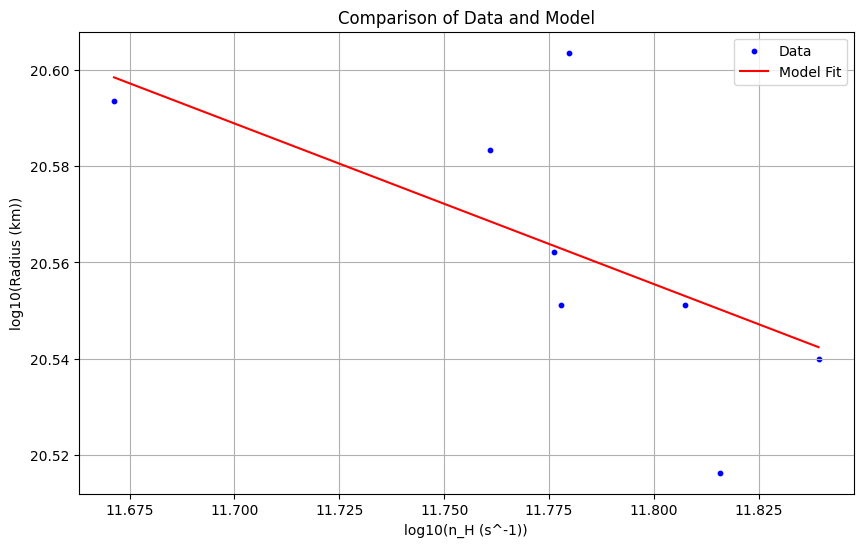

In [30]:
# Plotting the results 

plt.figure(figsize=(10, 6))
plt.scatter(n_H_log, Radius_log, label='Data', color='blue', s=10)
plt.plot(n_H_ordered, model(theta_max, n_H_ordered), label='Model Fit', color='red')
plt.xlabel('log10(n_H (s^-1))')
plt.ylabel('log10(Radius (km))')
plt.title('Comparison of Data and Model')
plt.legend()
plt.grid()
plt.show()


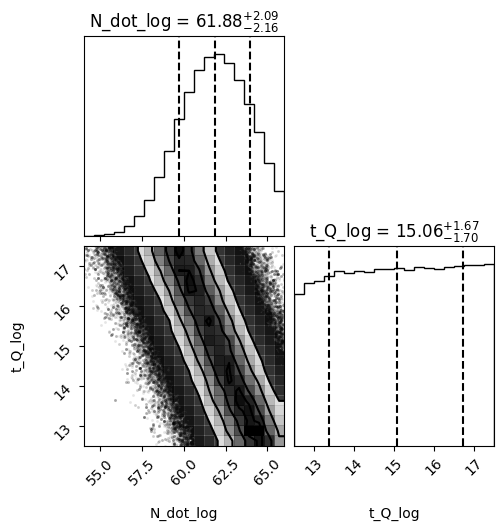

In [19]:
# Plotting a corner plot of the samples along with the quantiles

fig = corner.corner(samples, labels=["N_dot_log", "t_Q_log"],  quantiles=[0.16, 0.5, 0.84], show_titles=True, plot_datapoints=True)

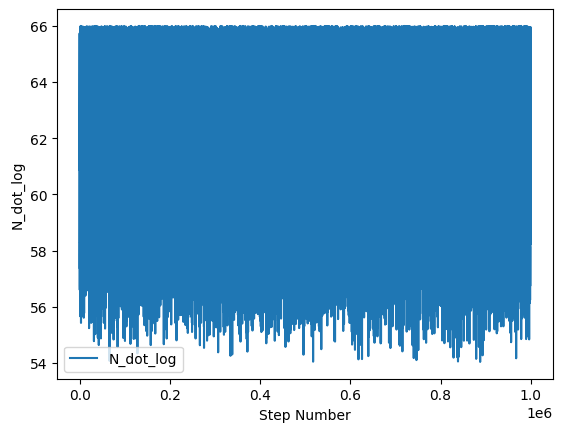

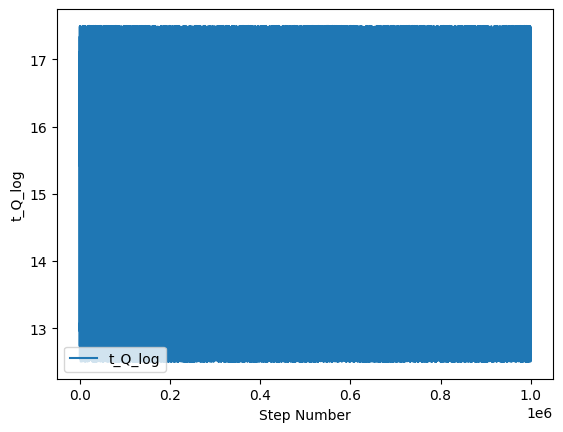

In [20]:
# Plotting the variation with time of the MCMC walkers

chains = sampler.chain[:, 50:, :].reshape((-1, ndim))

plt.plot(np.arange(len(chains[:, 0])), chains[:, 0], label='N_dot_log')
plt.xlabel('Step Number')
plt.ylabel('N_dot_log')
plt.legend()
plt.show()

plt.plot(np.arange(len(chains[:, 1])), chains[:, 1], label='t_Q_log')
plt.xlabel('Step Number')
plt.ylabel('t_Q_log')
plt.legend()
plt.show()

---

## Comparison with the input data set (Redundant Now)
 

Here I am performing the same MCMC sampling but with the input data, to compare the output with that of the previous scenario

In [21]:
# # Importing the input data
# ang_inp = np.array(data.radius_x)  # Input angular radius
                                            
# amp_inp = np.array(data.amp_x) * -1 * 1e-6  # The input amplitude is negative, so we multiply it with -1 (in Kelvin)

In [22]:
# # Calculating the actual distance and y

# Radius_inp = AngToDist(ang_inp)  # in Mpc

# y_inp = amp_inp / T_CMB.value

In [23]:
# # Calculating n_e and n_H

# n_e_inp = y * 3 * np.sqrt(1+z) / (sigma_T * 0.001 * 2 * Radius_inp.to('km'))

# n_H_inp = n_e_inp / (1 - f_H) 

In [24]:
# # Initializing the sampler for the input data

# sampler_inp = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n_H_inp, Radius_inp, Radius_err))


# # Running the MCMC Sampler

# # Burn-in phase
# print("Running burn-in phase...")
# sampler_inp.reset()
# state = sampler_inp.run_mcmc(p0, n_burn, progress=True)
# sampler_inp.reset()

# # Main sampling phase
# print("Running main sampling phase...")
# pos, prob, state = sampler_inp.run_mcmc(state, n_steps, progress=True)

# # Extracting the samples
# samples = sampler_inp.get_chain(flat=True) 


In [25]:
# # Comparing the N_dot and t_Q values from the input data with the output data
# theta_max_inp = samples[np.argmax(sampler_inp.flatlnprobability)]
# print("INPUT:  N_dot:", theta_max_inp[0], "; t_Q (in years):", theta_max_inp[1]/3.156e7 )
# print("OUTPUT: N_dot:", theta_max[0], "; t_Q (in years):", theta_max[1]/3.156e7 )

In [26]:
# # Comparing the Radii calculated from the input and output data
# print("INPUT: Radius:", model(theta_max_inp, n_H_inp).to('Mpc'))
# print("OUTPUT: Radius:", model(theta_max, n_H).to('Mpc'))

In [27]:
# # Actual Radius values
# print("Actual Radius:", Radius_inp)


In [28]:
# Radius

In [29]:
# model(theta_max, n_H).to('Mpc')